In [21]:
import tensorflow as tf
from tensorflow_model_optimization.python.core.keras.compat import keras

In [22]:
(x_train, y_train),(x_test,y_test)= keras.datasets.mnist.load_data()

In [23]:
x_train=x_train/255
x_test=x_test/255

In [24]:
x_train_flattened=x_train.reshape(len(x_train),28*28)
x_test_flattened=x_test.reshape(len(x_test),28*28)

In [25]:
model=keras.Sequential([
    keras.layers.Dense(10,activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(x_train_flattened,y_train,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4674 - accuracy: 0.8777
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3043 - accuracy: 0.9150
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2834 - accuracy: 0.9212
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2739 - accuracy: 0.9234
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2672 - accuracy: 0.9259


In [26]:
model.evaluate(x_test_flattened,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.2670 - accuracy: 0.9268


[0.2669830918312073, 0.926800012588501]

In [27]:
y_pred=model.predict(x_test_flattened)

313/313 [==============================] - 0s 1ms/step


In [28]:
import numpy as np

y_pred_lables=[np.argmax(i) for i in y_pred]

In [29]:
y_pred_lables[0]

np.int64(7)

In [30]:
cm=tf.math.confusion_matrix(labels=y_test,predictions=y_pred_lables)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 963,    0,    2,    2,    0,    5,    5,    2,    1,    0],
       [   0, 1118,    3,    2,    0,    1,    4,    2,    5,    0],
       [   6,    9,  927,   16,    6,    4,   12,   10,   37,    5],
       [   3,    0,   19,  909,    0,   39,    3,   10,   18,    9],
       [   2,    1,    5,    1,  908,    0,    9,    4,   10,   42],
       [   9,    3,    3,   25,    7,  789,   16,    4,   29,    7],
       [  13,    3,    8,    1,    7,    9,  912,    2,    3,    0],
       [   2,    9,   22,    6,    6,    1,    0,  942,    1,   39],
       [   6,   11,    6,   19,    9,   27,    9,   10,  867,   10],
       [  11,    7,    1,   10,   19,    9,    0,   14,    5,  933]],
      dtype=int32)>

<Axes: >

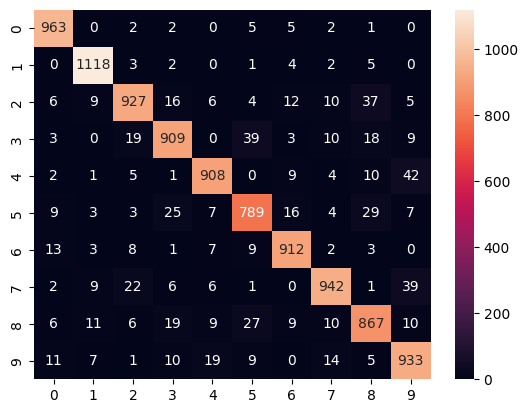

In [31]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

In [33]:
import tensorflow_model_optimization as tfmo

In [36]:
quant_mod=tfmo.quantization.keras.quantize_model
quant_aware_mod=quant_mod(model)
quant_aware_mod.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
quant_aware_mod.fit(x_train_flattened,y_train,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 2ms/step - loss: 0.2629 - accuracy: 0.9270
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2589 - accuracy: 0.9283
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2559 - accuracy: 0.9286
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2534 - accuracy: 0.9302
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2514 - accuracy: 0.9304


In [39]:
con=tf.lite.TFLiteConverter.from_keras_model(quant_aware_mod)
con.optimizations=[tf.lite.Optimize.DEFAULT]
tf_quant=con.convert()

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [41]:
len(tf_quant)

9840

In [40]:
with open('tf_quant.tflite','wb') as f:
    f.write(tf_quant)